@author Nassir Mohammad: <Nassir.Mohammad@airbus.com>

# Imports

In [2]:
import sys

# change path to where the PerceptionAlgorithm.py is located 
sys.path.append("/Users/.../perception")

In [3]:
import numpy as np
import pandas as pd

import time

# import visualisation 
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
from IPython.display import display
import matplotlib.dates as mdates

import csv
import os
import h5py

# import regex 
import glob
import re

# import math and science
import math
from math import exp, log
from decimal import *
import scipy.special as ss
from scipy import stats
from scipy.stats import kurtosis
from scipy import stats
from statsmodels import robust
import scipy.io
from scipy.io import loadmat

# import machine learning metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# import utilities
from itertools import product
import itertools

# Import models
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.abod import ABOD
from sklearn.cluster import DBSCAN

# set options
pd.options.display.max_columns = None
pd.set_option('display.max_columns', 400)
pd.options.mode.chained_assignment = None  # default='warn'

#from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from pyod.models.iforest import IForest
import datetime

#from PerceptionAlgorithm import Perception
from PerceptionAlgorithm import Perception

# Functions

## Evaluation functions

In [4]:
# code to plot scores and results i.e. AUC and precision/recall graphs

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds
    
    # ensure classes= is in correct order
def plot_confusion_matrix(cm, title, classes=['normal', 'abnormal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [5]:
def show_results(y_val, validation_labels, font_size, file_to_save, figure_title):
    
    X_val_anomalies = X_val[np.where(validation_labels==1)[0]]
    X_val_normal = X_val[np.where(validation_labels==0)[0]]

    fp = X_val[np.where((validation_labels == 1) & (y_val.T == 0))[1]]
    fn = X_val[np.where((validation_labels == 0) & (y_val.T == 1))[1]]

    for x in fp:
        X_val_anomalies = np.delete(X_val_anomalies, np.where(X_val_anomalies == x), axis=0)

    for x in fn:
        X_val_normal = np.delete(X_val_normal, np.where(X_val_normal == x), axis=0)

    plt.rcParams["font.size"] = font_size

    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.scatterplot(X_val_anomalies[:,0], X_val_anomalies[:,1], color='darkorange', label='anomaly (true +ve)')
    ax = sns.scatterplot(X_val_normal[:,0], X_val_normal[:,1], alpha=0.4, label='normal (true -ve)')
    plt.legend();

    ax = sns.scatterplot(fp[:,0], fp[:,1], color='purple', label='normal (false +ve)', marker='x')
    ax = sns.scatterplot(fn[:,0], fn[:,1], color='black', label='anomaly (false -ve)', marker=',')

    ax.set_title(figure_title, fontsize=18);
    plt.legend();

    print(classification_report(y_val, validation_labels, target_names=['normal', 'abnormal'],output_dict=False))

    auc_score = roc_auc_score(y_val, validation_labels)
    print('auc score: {}'.format(auc_score))

    #plt.savefig(image_save_path + file_to_save);

# Tutorial examples

## Example 1: hypothetical dataset for outlier detection paper

/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


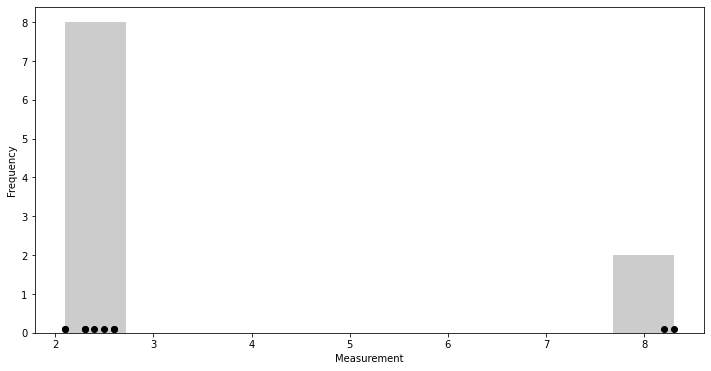

In [6]:
boris_hypo_1 = np.array([2.1, 2.6, 2.4, 2.5, 2.3, 2.1, 2.3, 2.6, 8.2, 8.3]) # Boris dataset - hypothetical

# seaborn histogram
f, axes = plt.subplots(figsize=(12,6))
sns.distplot(boris_hypo_1, hist=True, kde=False, rug=False,
             bins=10, color = 'grey',ax=axes,
             #hist_kws={'edgecolor':'black'}
            );

# Add labels
#plt.title('Hypothetical dataset')
plt.xlabel('Measurement')
plt.ylabel('Frequency');

axes.plot(boris_hypo_1, np.zeros_like(boris_hypo_1)+0.1, 'o', color='black');

In [7]:
# run anomaly detection

clf = Perception()
clf.fit(boris_hypo_1)
clf.predict(boris_hypo_1)

# print anomalies by position: 0 is normal, 1 is anomalous
print("anomaly labels: {}".format(clf.labels_))

# print associated anomaly scores: all scores > 0 are anomalous. 
# The greater the score, the more anomalous is the observation.
print("anomaly scores: {}".format(clf.scores_))

# print the anomaly values
print("anomalies: {}".format(clf.anomalies_))

anomaly labels: [0 0 0 0 0 0 0 0 1 1]
anomaly scores: [-0.06315493 -0.05209973 -0.01771219 -0.03806616 -0.03806616 -0.06315493
 -0.03806616 -0.05209973  0.34267118  0.35885167]
anomalies: [8.2 8.3]


## Example 2: Galton heights

/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


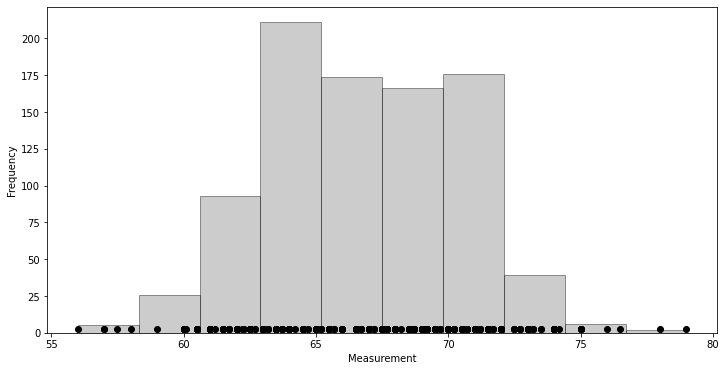

In [8]:
# ** modify file path **
galton_height_path = "/Users/.../data/Galton.txt"

g_df = pd.read_csv(galton_height_path, sep='\t', lineterminator='\r')

galton_heights = g_df['Height'].values

# seaborn histogram
f, axes = plt.subplots(figsize=(12,6))
sns.distplot(galton_heights, hist=True, kde=False, 
             bins=10, color = 'grey',ax=axes,
             hist_kws={'edgecolor':'black'});

# # Add labels
#plt.title('Galton height dataset')
plt.xlabel('Measurement')
plt.ylabel('Frequency');

axes.plot(galton_heights, np.zeros_like(galton_heights)+2.8, 'o', color='black');

In [9]:
# run anomaly detection

clf = Perception()
clf.fit(galton_heights)
clf.predict(galton_heights)

# print anomalies by position: 0 is normal, 1 is anomalous
#print("anomaly labels: {}".format(clf.labels_))

# print associated anomaly scores: all scores > 0 are anomalous. 
# The greater the score, the more anomalous is the observation.
#print("anomaly scores: {}".format(clf.scores_))

# print the anomaly values
print("anomalies: {}".format(clf.anomalies_))

anomalies: [56.  57.  57.  57.5 58.  75.  75.  75.  75.  76.  76.5 78.  79. ]


## Example 3: ex8data1 

In [10]:
# ** modify file path **
path = r"/Users/.../data/ex8data1.mat"

random_state = 42

data = loadmat(path)
X = data['X']
X_val = data['Xval']
y_val = data['yval']

# show the headers
for key, val in data.items():
    print(key)
    
print("The shape of X is: {}".format(X.shape))
print("The shape of X_val is: {}".format(X_val.shape))
print("The shape of y is: {}".format(y_val.sum()))

__header__
__version__
__globals__
X
Xval
yval
The shape of X is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y is: 9


/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


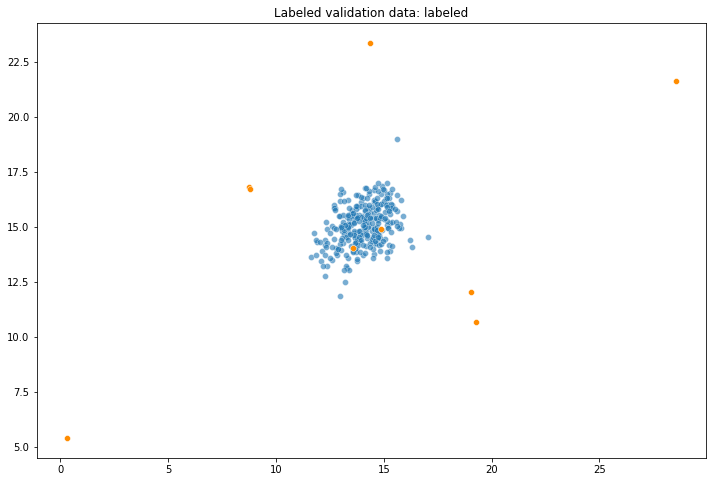

In [11]:
X_val_anomalies = X_val[np.where(y_val==1)[0]]
X_val_normal = X_val[np.where(y_val==0)[0]]

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.scatterplot(X_val_normal[:,0], X_val_normal[:,1], alpha=0.6)
ax = sns.scatterplot(X_val_anomalies[:,0], X_val_anomalies[:,1], color='darkorange', alpha=1)
ax.set_title("Labeled validation data: labeled");

### MCD (elliptic envelope) algorithm

              precision    recall  f1-score   support

      normal       0.99      0.92      0.95       298
    abnormal       0.23      0.78      0.35         9

    accuracy                           0.92       307
   macro avg       0.61      0.85      0.65       307
weighted avg       0.97      0.92      0.94       307

auc score: 0.84862043251305


/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an expli

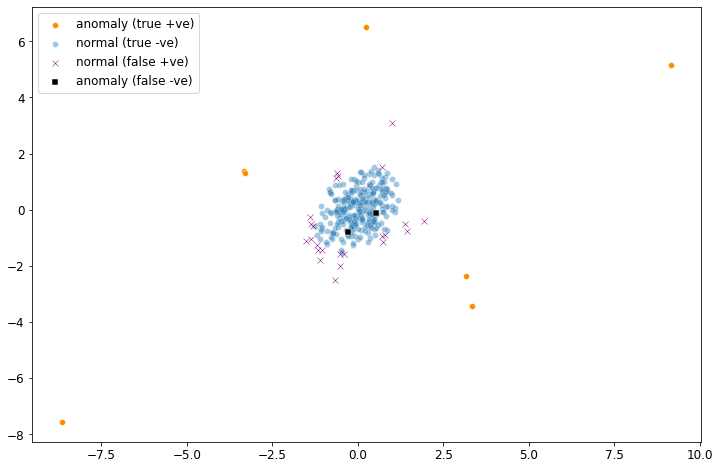

In [12]:
# apply MCD anomaly detector and show results
clf_mcd = MCD()

sc = StandardScaler()
sc.fit(X_val)
X_val = sc.transform(X_val)

# prediction
clf_mcd.fit(X_val)
validation_labels = clf_mcd.predict(X_val)
    
show_results(y_val, validation_labels, font_size="12", 
             file_to_save='ex8data1_validation_mcd.png',
            figure_title="") #MCD model results (validation data only)



### Perception 

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       298
    abnormal       0.64      0.78      0.70         9

    accuracy                           0.98       307
   macro avg       0.81      0.88      0.84       307
weighted avg       0.98      0.98      0.98       307

auc score: 0.8821774794929157


/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nassirmohammad/anaconda3/envs/conda_env1/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an expli

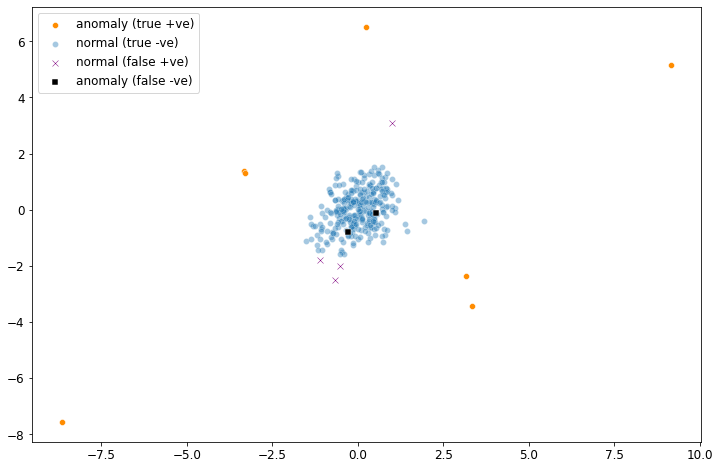

In [13]:
sc = StandardScaler()
sc.fit(X_val)
X_val = sc.transform(X_val)

clf_our = Perception()
clf_our.fit(X_val)
validation_labels = clf_our.predict(X_val)

validation_labels = clf_our.labels_

show_results(y_val, validation_labels, font_size="12", 
             file_to_save='ex8data1_validation.png',
            figure_title="")

## Example 4 

In [14]:
# ** modify file path **
path = r"/Users/.../data/ex8data2.mat"
random_state = 42

data = loadmat(path)
X2 = data['X']
X2_val = data['Xval']
y2_val = data['yval']

print(X2.shape, X2_val.shape, y2_val.shape)

# show the headers
for key, val in data.items():
    print(key)
    
print("The shape of X is: {}".format(X2.shape))
print("The shape of X_val is: {}".format(X2_val.shape))
print("The shape of y is: {}".format(y2_val.sum()))

(1000, 11) (100, 11) (100, 1)
__header__
__version__
__globals__
X
Xval
yval
The shape of X is: (1000, 11)
The shape of X_val is: (100, 11)
The shape of y is: 10


In [15]:
from IPython.core.debugger import set_trace
from sklearn.preprocessing import RobustScaler

random_state = 42

data = loadmat(path)
X2 = data['X']
X2_val = data['Xval']
y2_val = data['yval']

sc = StandardScaler()
sc.fit(X2)
X2 = sc.transform(X2)
X2_val = sc.transform(X2_val)

# build, fit and predict model
clf_our = Perception()
clf_our.fit(X2)
clf_our.predict(X2_val)

validation_labels = clf_our.labels_

print(classification_report(y2_val, validation_labels, target_names=['normal', 'abnormal'],output_dict=False))

auc_score = roc_auc_score(y2_val, validation_labels)
print('auc score: {}'.format(auc_score))

              precision    recall  f1-score   support

      normal       0.96      0.98      0.97        90
    abnormal       0.75      0.60      0.67        10

    accuracy                           0.94       100
   macro avg       0.85      0.79      0.82       100
weighted avg       0.94      0.94      0.94       100

auc score: 0.788888888888889
